<a href="https://colab.research.google.com/github/alanrolemberg/mvp/blob/main/MachineLearningMVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MVP - Machine Learning**

**Aluno:** ALAN ROLEMBERG ELIODORIO

**1. Contexto**

Temos um banco de dados com o histórico de **salários pagos** a profissionais de ciência de dados em diversas empresas. Além dos salários, o dataset nos traz informações características de cada vaga, como local de residência do empregado, local da empresa, taxa de trabalho remoto, entre outros dados interessantes. Com base nestes dados, tentaremos **predizer um valor de salário** para novos empregados, ou seja, é um problema de regressão. Este modelo pode ser usado para que empresas ofereçam salários justos (baseados em valor de mercado) para seus novos empregados.

**2. Estrutura**

O notebook está dividido em:

-  Importação de bibliotecas

-  Carga do dataset

-  Divisão entre treinamento e teste

-  Avaliação comparativa dos modelos

-  Uso do algoritmo de melhor avaliação

-  Avaliação dos atributos por Feature Selecition

**3. Dataset**

O dataset ds_salaries foi baixada do Kaggle, através do link [ds_salaries](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj9lvjiu9D_AhU_CLkGHcniBhAQFnoECBQQAQ&url=https%3A%2F%2Fwww.kaggle.com%2Fcode%2Fifeanyies%2Fds-salaries&usg=AOvVaw0AR50DRdSHC8J87Xz6Qy3C&opi=89978449) .

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes # para importar o dataset diabetes
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM

**CARGA DO DATASET ORIGINAL:**

In [ ]:
# Carga do dataset não tratado
#dataset = pd.read_csv('/content/ds_salaries_prepared6.csv',delimiter=';')
url = 'http://raw.githubusercontent.com/alanrolemberg/mvp/main/ds_salaries_prepared.csv'

# Carga do dataset não tratado
df_orig = pd.read_csv(url,delimiter=';',)

# Exibição das primeiras linhas do dataset
df_orig.head()


,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary,salary_in_usd
0,2023,SE,FT,Principal Data Scientist,EUR,ES,100,ES,L,80000,85847
1,2023,MI,CT,ML Engineer,USD,US,100,US,S,30000,30000
2,2023,MI,CT,ML Engineer,USD,US,100,US,S,25500,25500
3,2023,SE,FT,Data Scientist,USD,CA,100,CA,M,175000,175000
4,2023,SE,FT,Data Scientist,USD,CA,100,CA,M,120000,120000


**Pré-processamento dos dados:** Nosso problema é de regressão. NEste tipo de problema, para conseguirmos lidar com colunas do tipo texto, vamos convertê-las para pesos e/ou numerações que representem as categorias.

O atributo "Tamanho da empresa" será substituído pelos pesos a seguir: Pequena (Peso 5), Média (Peso 25), Grande (Peso 100).

Os atributos "País da empresa", "País do empregado", "Tipo de contratação" e "Nome do cargo" serão substituídos por codificações.

**Observação importante:** Tentamos fazer uso do "OneHotEncoding" e do "GetDummies" para evitar as substituições citadas acima, mas chegamos a conclusão de que a conversão para colunas binárias nos traria prejuízos na hora de se executar o processo de "Feature Selection", devido ao fato de que este processo "quebra" o atributo em vários atributos, modificando a condição da análise que é feita pelos algoritmos de "Feature Selection". Portanto, usamos a abordagem de substituição de variáveis por códigos ou pesos.

Removemos o atributo "salário" devido a redundância, e adotamos o atributo "salário em dólar" como atributo target para garantir uniformidade de medição.

Dessa forma iremos reimportar o dataset tratado para fins de comparação:


**CARGA DO DATASET:**


In [ ]:
url = 'https://raw.githubusercontent.com/alanrolemberg/mvp/main/ds_salaries_prepared6.csv'

df = pd.read_csv(url,delimiter=';')
df.head()

,work_year,Experience_level_coded,employment_type_code,job_title_code,employee_residence,remote_ratio,company_location,company_size_numeric,salary_in_usd
0,2023,3,3,86,65,100,65,100,85847
1,2023,2,1,78,228,100,228,5,30000
2,2023,2,1,78,228,100,228,5,25500
3,2023,3,3,48,36,100,36,25,175000
4,2023,3,3,48,36,100,36,25,120000


**Separação em base de treino e testes:**

Separamos nosso conjunto, destinando 80% para a base de treino e 20% para a base de testes.

In [ ]:
#Separação em bases de treino e teste (holdout)
array = df.values
X = array[:,0:8]
y = array[:,8] # classe (target)
print(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

[[2023    3    3 ...  100   65  100]
 [2023    2    1 ...  100  228    5]
 [2023    2    1 ...  100  228    5]
 ...
 [2020    1    3 ...  100  228    5]
 [2020    1    1 ...  100  228  100]
 [2021    3    3 ...   50  103  100]]


**Modelagem:**

Criamos nosso modelo e adicionamos 5 algoritmos de regressão para gerar as análises do modelo. A métrica para avaliação dos modelos será o erro quadrático médio, através do método de validação cruzada.

LR: MSE 2992400074.39 (403308434.59) - RMSE 54702.83
Ridge: MSE 2992270706.35 (403138735.34) - RMSE 54701.65
Lasso: MSE 2992356821.02 (403255496.92) - RMSE 54702.44
KNN: MSE 2946590872.46 (420224324.38) - RMSE 54282.51
CART: MSE 2951575054.03 (369578566.93) - RMSE 54328.40
SVM: MSE 4018742618.61 (465318464.50) - RMSE 63393.55


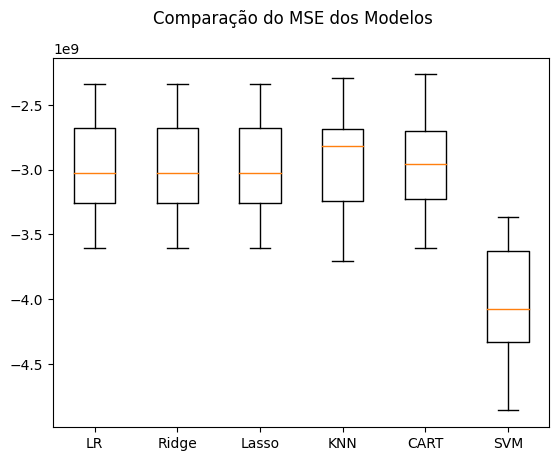

In [ ]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)


# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**DESCOBERTA:** O KNN é o modelo que trouxe melhor performance com este DATASET.

**Avaliação do modelo vencedor com todo o conjunto de teste:**

In [ ]:
# Criando um modelo com todo o conjunto de treino
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 2737845613.44
RMSE 52324.43


**IMPORT DAS BIBLIOTECAS DE FEATURE SELECTION**

In [ ]:
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.linear_model import LogisticRegression # Regressão Logística, para a Eliminação Recursiva de Atributos
from sklearn.ensemble import ExtraTreesClassifier # ExtraTrees, para a Importância de Atributos

In [ ]:
# SelectKBest

# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_classif, k=4)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", df.columns[0:8])

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=df.columns[0:8]))


Número original de atributos: 8

Número reduzido de atributos: 4

Atributos Originais: Index(['work_year', 'Experience_level_coded', 'employment_type_code',
       'job_title_code', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size_numeric'],
      dtype='object')

Scores dos Atributos Originais: [3.013 2.919 2.756 1.911 8.981 2.    9.421 3.408]

Atributos Selecionados: ['work_year' 'employee_residence' 'company_location'
 'company_size_numeric']


**Descoberta:** Este algoritmo classificou os atributos ['work_year' 'employee_residence' 'company_location'
 'company_size_numeric'] como os mais importantes.

In [ ]:
# Eliminação Recursiva de Atributos

# Criação do modelo
modelo = LogisticRegression(max_iter=200)

# Descobrir 3 atributos com maior influência nos resultados
rfe = RFE(modelo, n_features_to_select=3)
fit = rfe.fit(X, y)

# Print dos resultados
print("Atributos Originais:", df.columns[0:8])

# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
# e com valor 1 em "Ranking dos Atributos")
print("\nAtributos Selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)
print("\nNomes dos Atributos Selecionados como melhores: %s" % fit.get_feature_names_out(input_features=df.columns[0:8]))

Atributos Originais: Index(['work_year', 'Experience_level_coded', 'employment_type_code',
       'job_title_code', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size_numeric'],
      dtype='object')

Atributos Selecionados: [False False False  True False  True False  True]

Ranking de atributos: [4 5 6 1 2 1 3 1]

Qtd de melhores Atributos: 3

Nomes dos Atributos Selecionados como melhores: ['job_title_code' 'remote_ratio' 'company_size_numeric']


**Descoberta:** Este algoritmo classificou os atributos ['job_title_code' 'remote_ratio' 'company_size_numeric'] como os mais importantes.

In [ ]:
# Importância de Atributos com ExtraTrees

# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)

# Exibe os atributos orginais
print("\nAtributos Originais:", df.columns[0:8])

# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print(modelo.feature_importances_)

print(" O melhor atributo tem importancia de: ",max(modelo.feature_importances_))


Atributos Originais: Index(['work_year', 'Experience_level_coded', 'employment_type_code',
       'job_title_code', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size_numeric'],
      dtype='object')
[0.121 0.073 0.019 0.425 0.124 0.055 0.116 0.067]
 O melhor atributo tem importancia de:  0.4251627715682816


**Redução da dimensionalidade**

Dentro do estudado, vamos então refazer a predição nos baseando apenas nos atributos mais importantes.

Descartaremos os atributos a seguir, que foram por mostrados como menos importantes por alguns dos algoritmos:
- experience_level_coded
- employment_type_code
- remote_ratio


In [ ]:
#Separação em bases de treino e teste (holdout)
array2 = df.values
# Concatenando apenas as colunas com os atributos selecionados
X2 = np.column_stack((array2[:,0],array2[:,3],array2[:,4],array2[:,6],array2[:,7]))
y2 = array2[:,8] # classe (target)
print(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=7) # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

[[2023   86   65   65  100]
 [2023   78  228  228    5]
 [2023   78  228  228    5]
 ...
 [2020   48  228  228    5]
 [2020   18  228  228  100]
 [2021   46  103  103  100]]


***NOVA MODELAGEM - APLICANDO FEATURE SELECTION ***

LR: MSE 3123465058.88 (387247377.00) - RMSE 55887.97
Ridge: MSE 3123464428.76 (387265732.97) - RMSE 55887.96
Lasso: MSE 3123464979.46 (387251245.21) - RMSE 55887.97
KNN: MSE 3104259693.94 (391861136.10) - RMSE 55715.88
CART: MSE 2904858721.84 (344994540.70) - RMSE 53896.74
SVM: MSE 4018711724.46 (465317281.71) - RMSE 63393.31


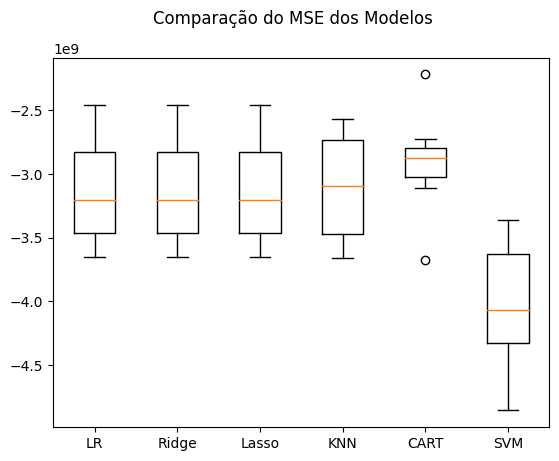

In [ ]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train2, y_train2, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)


# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**DESCOBERTA:** Nesta nova modelagem, após feature selection, o CART (Árvore de descisão) superou o KNN, demonstrando uma menor média no erro quadrático.

Vamos realizar agora o treino com todo o conjunto de treino para a comparação.

In [ ]:
# Criando um modelo com todo o conjunto de treino
model = DecisionTreeRegressor()
model.fit(X_train2, y_train2)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test2)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test2, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 2817821970.17
RMSE 53083.16


**PIORA NO DESEMPENHO:** O resultado global na avaliação da base de testes completa piorou após remover os atributos selecionados por feature selection, pois o erro quadrático médio que era de 52324 subiu para 53083.

**TESTANDO A PREDIÇÃO**

Vamos vistoriar uma amostragem das nossas predições, usando entradas da base de teste e notando o nível de aproximação das previsões de salário dos salários reais.

In [ ]:
numbers = [1, 2, 3, 4, 5]
for n in numbers:
  print('Atributos: ',X_test2[n],'| Salário: ', y_test2[n],'| Predição do modelo: ', round(predictions[n],0))


Atributos:  [2022   34  228  228   25] | Salário:  135000 | Predição do modelo:  150016.0
Atributos:  [2021   71  103  103   25] | Salário:  12171 | Predição do modelo:  20000.0
Atributos:  [2023   34  228  228   25] | Salário:  185000 | Predição do modelo:  154486.0
Atributos:  [2022   26  228  228   25] | Salário:  150000 | Predição do modelo:  116919.0
Atributos:  [2022   34  228  228   25] | Salário:  185900 | Predição do modelo:  150016.0


In [ ]:
# Plotagem dos resultados com DecisionTree
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot(data[:,0], m*data[:,0] + b,color='red',label='Our Fitting
Line')
plt.scatter(y_test2, predictions)

SyntaxError: ignored

Quanto mais a plotagem acima se aproxima de uma reta, mais preciso está o modelo.

**OTIMIZAÇÃO DE HIPERPARAMETROS**

In [ ]:
# Imports de Bibliotecas adicionais
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


Usaremos os parâmetros a seguir para o algoritmo de árvore de decisão:
*   'max_depth': [5,10,20,50]
*   'max_leaf_nodes': [1,5,10,20,30,40,50,80,100,500]
*   'min_samples_leaf': [1,5,10,20,40]







In [ ]:
# Tuning do DecisionTree

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
cart = ('CART', DecisionTreeRegressor())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('CART-orig', Pipeline(steps=[cart])))
pipelines.append(('CART-padr', Pipeline(steps=[standard_scaler, cart])))
pipelines.append(('CART-norm', Pipeline(steps=[min_max_scaler, cart])))

param_grid = {
    'CART__max_depth': [5,10,20,50],
    'CART__max_leaf_nodes': [1,5,10,20,30,40,50,80,100,500],
    'CART__min_samples_leaf': [1,5,10,20,40]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
    grid.fit(X_train2, y_train2)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Temos agora os melhores valores para os parâmetros testados, que devem incrementar nossos resultados de predição.

Testaremos agora a predição do melhor modelo entre o original, o padronizado e o normalizado. Na consulta anterior vimos que a melhor pontuação do GridSearch veio do modelo padronizado.

In [ ]:
# Criando um modelo configurado com os HIPER PARAMETROS e sem feature selection
model = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=40, min_samples_leaf=20) # Aplicação dos parametros eleitos para otimização de hiperparametros
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
tuned_predictions = model.predict(X_test)

# Estimando o MSE e o RMSE, após otimização de hiperparametros, no conjunto de teste
mse = mean_squared_error(y_test, tuned_predictions)
print("Original sem F.S.    | "+"MSE %0.2f" % mse + "| RMSE %0.2f" % np.sqrt(abs(mse)))




In [ ]:
# Criando um modelo configurado com os HIPER PARAMETROS e com feature selection
model = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=40, min_samples_leaf=20) # Aplicação dos parametros eleitos para otimização de hiperparametros
model.fit(X_train2, y_train2)

# Fazendo as predições com o conjunto de teste
tuned_predictions = model.predict(X_test2)

# Estimando o MSE e o RMSE, após otimização de hiperparametros, no conjunto de teste
mse = mean_squared_error(y_test2, tuned_predictions)
print("Original com F.S.   | "+"MSE %0.2f" % mse + "| RMSE %0.2f" % np.sqrt(abs(mse)))




In [ ]:
#------
# Criando um modelo configurado com os HIPER PARAMETROS e PADRONIZADO  e sem feature selection
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
X_train_r = scaler.transform(X_train) # aplicação da padronização no conjunto de treino

model = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=40, min_samples_leaf=20) # Aplicação dos parametros eleitos para otimização de hiperparametros
model.fit(X_train_r, y_train)

# Fazendo as predições com o conjunto de teste padronizado
scaler = StandardScaler().fit(X_test)
X_test_r = scaler.transform(X_test)
tuned_predictions_padr = model.predict(X_test_r)

# Estimando o MSE e o RMSE, após otimização de hiperparametros, no conjunto de teste
mse = mean_squared_error(y_test, tuned_predictions_padr)
print("Padronizado sem F.S. | "+"MSE %0.2f" % mse + "| RMSE %0.2f" % np.sqrt(abs(mse)))


In [ ]:
#------
# Criando um modelo configurado com os HIPER PARAMETROS e PADRONIZADO  e com feature selection
scaler = StandardScaler().fit(X_train2) # ajuste do scaler com o conjunto de treino
X_train2_r = scaler.transform(X_train2) # aplicação da padronização no conjunto de treino

model = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=40, min_samples_leaf=20) # Aplicação dos parametros eleitos para otimização de hiperparametros
model.fit(X_train2_r, y_train2)

# Fazendo as predições com o conjunto de teste padronizado
scaler = StandardScaler().fit(X_test2)
X_test2_r = scaler.transform(X_test2)
tuned_predictions_padr = model.predict(X_test2_r)

# Estimando o MSE e o RMSE, após otimização de hiperparametros, no conjunto de teste
mse = mean_squared_error(y_test2, tuned_predictions_padr)
print("Padronizado com F.S. | "+"MSE %0.2f" % mse + "| RMSE %0.2f" % np.sqrt(abs(mse)))

In [ ]:
#------
# Criando um modelo configurado com os HIPER PARAMETROS e NORMALIZADO e sem feature selection
scaler = MinMaxScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
X_train_r = scaler.transform(X_train) # aplicação da normalização no conjunto de treino

model = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=40, min_samples_leaf=20) # Aplicação dos parametros eleitos para otimização de hiperparametros
model.fit(X_train_r, y_train)

# Fazendo as predições com o conjunto de teste normalizado
scaler = MinMaxScaler().fit(X_test)
X_test_r = scaler.transform(X_test)
tuned_predictions_norm = model.predict(X_test_r)

# Estimando o MSE e o RMSE, após otimização de hiperparametros, no conjunto de teste
mse = mean_squared_error(y_test, tuned_predictions_norm)
print("Normalizado sem F.S. | "+"MSE %0.2f" % mse + "| RMSE %0.2f" % np.sqrt(abs(mse)))

In [ ]:
#------
# Criando um modelo configurado com os HIPER PARAMETROS e NORMALIZADO e com feature selection
scaler = MinMaxScaler().fit(X_train2) # ajuste do scaler com o conjunto de treino
X_train2_r = scaler.transform(X_train2) # aplicação da normalização no conjunto de treino

model = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=40, min_samples_leaf=20) # Aplicação dos parametros eleitos para otimização de hiperparametros
model.fit(X_train2_r, y_train2)

# Fazendo as predições com o conjunto de teste normalizado
scaler = MinMaxScaler().fit(X_test2)
X_test2_r = scaler.transform(X_test2)
tuned_predictions_norm = model.predict(X_test2_r)

# Estimando o MSE e o RMSE, após otimização de hiperparametros, no conjunto de teste
mse = mean_squared_error(y_test2, tuned_predictions_norm)
print("Normalizado com F.S. | "+"MSE %0.2f" % mse + "| RMSE %0.2f" % np.sqrt(abs(mse)))

**CONCLUSÕES:**
- O uso de HIPER PARAMETROS melhorou o modelo. (Vamos usar) ✅
- O uso de Feature Selection piorou um pouco o modelo. (Não vamos usar) 🚫
- O uso de normalização piorou um pouco o modelo. (Não vamos usar) 🚫
- O uso de padronização piorou muito o modelo. (Não vamos usar) 🚫

**GANHO SIGNIFICATIVO:**
O RMSE caiu de 53083.16 para 49007.52 após otimização de HIPER PARAMETROS. ✅

In [ ]:
# Plotagem dos resultados com DecisionTree após otimização de hiperparametros
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.scatter(y_test2, tuned_predictions)

**ANÁLISE DO PLOT:** Quanto mais a plotagem acima se aproxima de uma reta, mais preciso está o modelo, e quanto mais ele se difunde, menos preciso ele está (maior é o RMSE).



**PERSISTINDO O MODELO**



In [ ]:
# Salvar modelo para o disco
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))


**RECUPERANDO O MODELO**


In [ ]:
# Carregando o modelo e testando o RMSE novamente
loaded_model = pickle.load(open(filename, 'rb'))

model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
tuned_predictions = model.predict(X_test)

# Estimando o MSE e o RMSE, após otimização de hiperparametros, no conjunto de teste
mse = mean_squared_error(y_test, tuned_predictions)
print("Original sem F.S.    | "+"MSE %0.2f" % mse + "| RMSE %0.2f" % np.sqrt(abs(mse)))